# Fashion MNIST Classification
- with a linear network
- https://github.com/zalandoresearch/fashion-mnist
    - 60000 training, 10000 test
    - $28\times28$ grayscale
    - Highest test accuracy: 0.939 by Google AutoML, 24 compute hours
- https://github.com/dsgiitr/d2l-pytorch/tree/master/Ch05_Linear_Neural_Networks

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import sys
import os
import time

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
xforms = transforms.Compose([transforms.ToTensor(),
                             ])

dataset = {'train': torchvision.datasets.FashionMNIST('../data', train=True, download=True, transform=xforms),
           'val' : torchvision.datasets.FashionMNIST('../data', train=False, download=True, transform=xforms) }

In [0]:
def get_data_loader(batch_size):
    data_loader = { tv: torch.utils.data.DataLoader(dataset[tv], batch_size=batch_size, shuffle=True)
                   for tv in dataset.keys()}
    return data_loader

batch_size = 128
data_loader = get_data_loader(batch_size)

## Training Loop

In [0]:
loss_fn = nn.CrossEntropyLoss()

def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None, lr_scheduler=None):
    if hist is not None:
        pass
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
    #
    if lr_scheduler is not None:
        lr = []
        
    best_acc = 0
    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        # end mini-batch loop
        
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val)
        
        if epoch <= 5 or epoch % 10 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.4f} t_acc: {tr_acc:.4f}  vloss {val_loss:.4f}  v_acc: {val_acc:.4f}')
        
        # best accuracy
        if best_acc < val_acc:
            best_acc = val_acc
            print(f' >> best val accuracy updated: {best_acc} at epoch {epoch}.')
        #
        # record for history return
        if hist is not None:
            hist['tloss'].append(tr_loss)
            hist['vloss'].append(val_loss) 
            hist['tacc'].append(tr_acc)
            hist['vacc'].append(val_acc)
            
        if lr_scheduler is not None:
            lr.append(lr_scheduler.get_last_lr()) # the lr used in optim.
            lr_scheduler.step()
        # end epoch-loop
        
    if lr_scheduler is not None:
        hist['lr'] = lr
        
    print ('finished training_loop().')
    return hist
#

def performance(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    return loss, acc
#
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    max_vacc = max(history['vacc'])
    axes[1].set_title(f'Acc. vbest: {max_vacc:.2f}')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()
#

## Model with Three Linear Blocks

In [0]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 784) # (Batch, Features)

In [0]:
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, shortcut = False):
        super().__init__()
        
        self.Linear = nn.Linear(in_features = in_features, out_features = out_features)
        self.BatchNorm = nn.BatchNorm1d(out_features)
        self.ELU = nn.ELU()

    def forward(self, x):
        x = self.Linear(x)
        x = self.BatchNorm(x)
        x = self.ELU(x)

        return x


class LinearModel(nn.Module):
    def __init__(self, n_features, n_target):
        super().__init__()
        self.Reshape = Reshape()
        self.Hidden_1 = LinearBlock(n_features, n_features//2 )  
        self.Hidden_2 = LinearBlock(n_features//2, n_features//4) 
        self.Hidden_3 = LinearBlock(n_features//4, n_features//8) 
        self.Linear = nn.Linear(n_features//8, n_target)
        self.activation = nn.LogSoftmax(dim = 1)

    def forward(self, input):
        x = self.Reshape(input)
        x = self.Hidden_1(x)
        x = self.Hidden_2(x)
        x = self.Hidden_3(x)
        x = self.Linear(x)
        x = self.activation(x)

        return x

In [0]:
n_features = 28*28
n_targets = 10

In [54]:
model = LinearModel(n_features, n_targets,)
model

LinearModel(
  (Reshape): Reshape()
  (Hidden_1): LinearBlock(
    (Linear): Linear(in_features=784, out_features=392, bias=True)
    (BatchNorm): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ELU): ELU(alpha=1.0)
  )
  (Hidden_2): LinearBlock(
    (Linear): Linear(in_features=392, out_features=196, bias=True)
    (BatchNorm): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ELU): ELU(alpha=1.0)
  )
  (Hidden_3): LinearBlock(
    (Linear): Linear(in_features=196, out_features=98, bias=True)
    (BatchNorm): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ELU): ELU(alpha=1.0)
  )
  (Linear): Linear(in_features=98, out_features=10, bias=True)
  (activation): LogSoftmax()
)

## Train Setting

In [0]:
model = LinearModel(n_features, n_targets).to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

criterion = torch.nn.CrossEntropyLoss().to(device)
history = None

## Training

In [61]:
%%time
history = training_loop(40, optimizer, model, criterion, data_loader['train'], data_loader['val'], history, stepLR )

Epoch 1, tloss 0.6085 t_acc: 0.7779  vloss 0.5079  v_acc: 0.8189
 >> best val accuracy updated: 0.8189 at epoch 1.
Epoch 2, tloss 0.4276 t_acc: 0.8450  vloss 0.5098  v_acc: 0.8277
 >> best val accuracy updated: 0.8277 at epoch 2.
Epoch 3, tloss 0.3860 t_acc: 0.8613  vloss 0.4431  v_acc: 0.8422
 >> best val accuracy updated: 0.8422 at epoch 3.
Epoch 4, tloss 0.3558 t_acc: 0.8714  vloss 0.3795  v_acc: 0.8642
 >> best val accuracy updated: 0.8642 at epoch 4.
Epoch 5, tloss 0.3280 t_acc: 0.8810  vloss 0.3824  v_acc: 0.8651
 >> best val accuracy updated: 0.8651 at epoch 5.
 >> best val accuracy updated: 0.8673 at epoch 6.
 >> best val accuracy updated: 0.8683 at epoch 8.
 >> best val accuracy updated: 0.8816 at epoch 9.
Epoch 10, tloss 0.2509 t_acc: 0.9049  vloss 0.3472  v_acc: 0.8841
 >> best val accuracy updated: 0.8841 at epoch 10.
 >> best val accuracy updated: 0.8895 at epoch 14.
 >> best val accuracy updated: 0.8911 at epoch 15.
 >> best val accuracy updated: 0.8946 at epoch 18.
Epoch

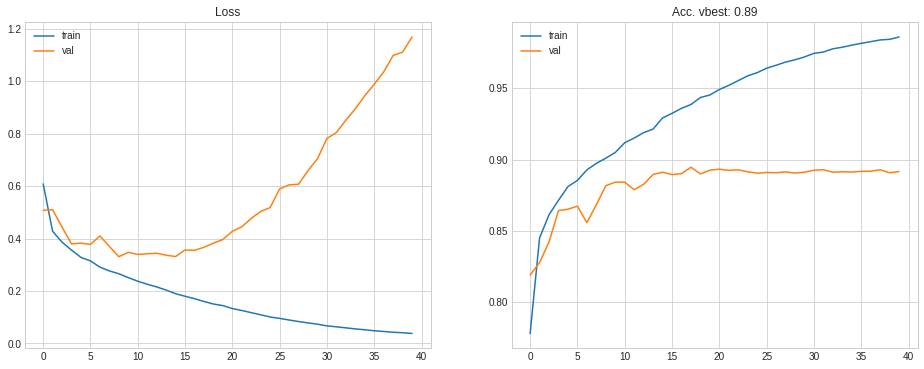

In [62]:
plot_history(history)

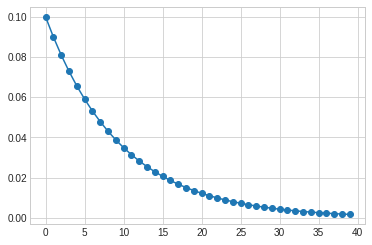

In [63]:
plt.plot(history['lr'], '-o')

End.